<a href="https://colab.research.google.com/github/xuebingwu/Pangolin-splice-site-prediction/blob/main/predict_splice_sites_in_a_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict 5' and 3' splice sites from a single sequence using *Pangolin*
* Find all potential 5' splice sites and 3' splice 
sites from a single sequence 
* Use deep learning models trained in four human tissues: heart, liver, brain, and testis (*Pangolin*: [Zeng and Li, Genome Biology 2022](https://doi.org/10.1186/s13059-022-02664-4)) 
* To run: enter your sequence in step 2, then hit `Runtime` -> `Run all` in the dropdown menu above
* To run individual step, click the triangle run/play button beneath the title of each step
* (Optional) To use GPU, hit: `Runtime` -> `Change runtime type` -> `GPU`.


In [ ]:
#@title Step 1: Install packages (~50 seconds)

#@markdown - Only need to install once
#@markdown - No need to run this cell/block if repeating with a new sequence

!pip install pyvcf gffutils biopython pandas pyfastx
!git clone https://github.com/xuebingwu/Pangolin-splice-site-prediction.git
%cd Pangolin-splice-site-prediction
!pip install .
%cd /content

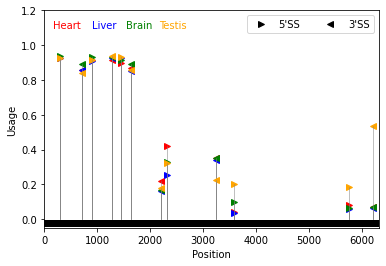



Predicted splice sites

Position	sequence	Type	Heart	Liver	Brain	Testis
-----------------------------------------------------------------------
303 	 GAGGACCCGCGgtgaggcgg	5'SS	0.927	0.928	0.939	0.926
720 	 gatcccgcagAGACGCGGAA	3'SS	0.86	0.859	0.893	0.842
904 	 GGTTGTCTCTGgtgagtgta	5'SS	0.912	0.907	0.932	0.913
1274 	 actttttcagGACTGCCTCC	3'SS	0.917	0.925	0.932	0.935
1446 	 GATCTCATGAGgtaggttat	5'SS	0.9	0.924	0.915	0.93
1647 	 tatccaatagGGAGAAACTG	3'SS	0.867	0.852	0.894	0.857
2206 	 ctttctgtagACATATCTGA	3'SS	0.219	0.16	0.165	0.178
2324 	 TGGAGGCAATGgtatgactc	5'SS	0.423	0.256	0.329	0.32
3246 	 ggttataaagGTTTGGATTG	3'SS	0.352	0.34	0.353	0.223
3596 	 ACGAGTAGATGgtaaacatt	5'SS	0.038	0.033	0.097	0.202
5758 	 GGAAACAAAAGgtaagaaac	5'SS	0.08	0.056	0.065	0.182
6208 	 tccatcacagTATGAAGACT	3'SS	0.072	0.061	0.07	0.537

Columns:
Position:	Site position in the sequence
sequence:	20-nt junction sequence. Intron-lower case; Exon-upper case
Type    :	5' splice site (5'SS), 3' splice site (3'SS), or Und

In [1]:
#@title Step 2: Analyze your DNA sequence (~15s with CPU, ~1s with GPU)

SEQUENCE = "GCCATTTTGGAGGGGCCGCGGGAGACGTGGTGCCGCTGCGGGCTCGCTCT GCCGTGCGCTAGGCTTGGTGGGAAGGCCTGTTCTCGAGTCCGCGCTTTTC GTCACCGCCATGTCGGGAGGTGGTGTGATTCGTGGCCCCGCAGGGAACAA CGATTGCCGCATCTACGTGGGTAACTTACCTCCAGACATCCGAACCAAGG ACATTGAGGACGTGTTCTACAAATACGGCGCTATCCGCGACATCGACCTC AAGAATCGCCGCGGGGGACCGCCCTTCGCCTTCGTTGAGTTCGAGGACCC GCGGTGAGGCGGCATGGGGCTTGCAGCCTTGAGGAAATAGGTCCGAGTAG TTGGGGAAGGCTCCAAGGCCTTAACATAGAGAACGGGGAAGCGGGGGCTC TTAGAGAGGTTGGGGCGAGACTGTATCGCCCATGCAGGAGTCGAGTAAGG AGCTGAGTTGATGTGGCTTCTCTGGCGCCTCGCCTTGGACGTCCCCGGAG CCCATTCGCAGGCTGGAGCGGGAAACTGAGGCGCTGAGGGCTGGTGTAGT GGTTGGGAGCCTGGCGTGTTTCTGGGTGGGGGAGGGGCCATTCCTATTAT GCGGCGCATGTGGGCTCTTCCACGTTGGGTGCGCATGTGCGGGGGGTTTG CTGGTTCCCAACTGAGCGAGCTTCTCCTCCTGGTGTTTCTCATCCCTTTT ACTTTCTGCGATCCCGCAGAGACGCGGAAGACGCGGTGTATGGTCGCGAC GGCTATGATTACGATGGGTACCGTCTGCGGGTGGAGTTTCCTCGAAGCGG CCGTGGAACAGGCCGAGGCGGCGGCGGGGGTGGAGGTGGCGGAGCTCCCC GAGGTCGCTATGGCCCCCCATCCAGGCGGTCTGAAAACAGAGTGGTTGTC TCTGGTGAGTGTACTGGTTGTGTGGATTGATGTGAAGGGACGAAAACTAC CTAAAATTTTTCTCTTGCGTGACAGGTTTAATAATTGCAAATTTTTCATG CTAGGTCTTAAATTGCTTTAGTTTTTGGGTGAATTTAATAAACGAGGATT GCTGCTGTGGTGATTTACCAAATTAGGTTGCGGTACTAGATACGAAGATC GTTACAAATAATTTTGGACTCTGGATTCCAGAATCTTACCAGCTCTCTTT ACCTGGTATCACTTAAGTACACCTATTAAGTACTTTAAAGTACTCTTTGT CCTAATGTACCTTACCAGCTTAACGTGAAATTTAAGATAATTGGTACTAA GAAAAAAAAAATCACTTTTTCAGGACTGCCTCCAAGTGGAAGTTGGCAGG ATTTAAAGGATCACATGCGTGAAGCAGGTGATGTATGTTATGCTGATGTT TACCGAGATGGCACTGGTGTCGTGGAGTTTGTACGGAAAGAAGATATGAC CTATGCAGTTCGAAAACTGGATAACACTAAGTTTAGATCTCATGAGGTAG GTTATACACGTATTCTTTTCTTTGACCAGAATTGGATACAGTGGTCTTAA CAGTGGAATTTCAAGGTAAGGATTCAGGCAAGGTTGTCCAAGTAAATTGC CAGATTTCTGGTTTTAGTTACATTGTATTCATTCAGCATGTCTGAAGATA GATGAAAGCTTAGATCTTTCAATGGAAAGTTCTGTCTATCCAATAGGGAG AAACTGCCTACATCCGGGTTAAAGTTGATGGGCCCAGAAGTCCAAGTTAT GGAAGATCTCGATCTCGAAGCCGTAGTCGTAGCAGAAGCCGTAGCAGAAG CAACAGCAGGAGTCGCAGTTACTCCCCAAGGAGAAGCAGAGGATCACCAC GCTATTCTCCCCGTCATAGCAGATCTCGCTCTCGTACATAAGATGATTGG TGACACTTTTTGTAGAACCCATGTTGTATACAGTTTTCCTTTATTCAGTA CAATCTTTTCATTTTTTAATTCAAACTGTTTTGTTCAGAATGGGCTAAAG TGTTGAATTGCATTCTTGTAATATCCCCTTGCTCCTAACATCTACATTCC CTTCGTGTCTTTGATAAATTGTATTTTAAGTGATGTCATAGACAGGATTG TTTAAATTTAGTTAACTCCATACTCTTCAGACTGTGATATTGTGTAAATG TCTATCTGCCCTGGTTTGTGTGAACTGGGATGTTGGGGGTGTTTGTGGTT ATCTTACCTGGGGAAGTTCTTATGTTTATCTTGCTTTTCATGTGTCTTTC TGTAGACATATCTGAAGAGATGGATTAAGAATGCTTTGGATTAAGGATTG TGGAGCACATTTCAATCATTTTAGGATTGTCAAAAGGAGGATTGAGGAGG ATCAGATCAATAATGGAGGCAATGGTATGACTCCAAGTGCTATTGTCACA GATGAAATTGGCAGTATTGACCTTATACTAAAAGGCAGGGGTTAAAAATG ATTATATACATTTTCCTTAAAACACTTGCAAACATTTTATTCAGTTGTCT TTAGCTACAATTGCTTTGCTTTTTAAACCTTGGCAATTGTGGCAAAATTA TATTGCCCATTTTGTAGCAACTTATTTTGCTCCCTTCCCCCCATTTTTGT TTTAATAGGGACTAATGTGGGAAGAACTGGCTAATTTGTCACAGTGCTTA GTTACAACTGTTAATGTGTGACCTGCTGTTGGTGTACATGTGGGTACAGG GTGTTTTTAAATCCAACAAGATAGAGTATAATATCAATACTGCTAAATCT GCATGTCCTCTGTGTGACTGATAGAGCGTTGCTATTTCATTTTTTTAAGA CAAAATGAAAGCAAAATATAGAGTTCCAATGTATTGGTGTAGATAATCTA GTTGGGAATACTTTTAAGTCTCACCTTCCCCTTTAAACTAATATTCATAA TTGGTTCATATGTTTAAAAGACTTTAATTTACAAATTAAATTGCAAATGG GAGCATTAGATTTAGTTTTAGACTTAGGTGGGTAGCAATGCCAGTAAACT TAAATTACGTAACTTCTTGCAACCACGAAACCTGTAATACGCTGTACAGT AACAAGTGTTGGCATTATCAGTTGAACTGTAAATACAAAATGCTTCTTCC AATTAGTCTCTATGATGATTAAGTTTCTAAAATTTATCTGAACACCATTC AGAAACTTGTTTTGGGGAATTTGATAGTTATTGATGTGCATCTGTTAAAC TGATGACAGACATAACTCATCATTCCCCAGAAACCTTTTTTGATTACAGT ATCTAACATTTTGCCTCCTCTTTTTTGGTTTTGCTGGTTATAAAGGTTTG GATTGGAGAGGGCTCACTGGATCCCAATCCTTGGAGCTGGATCATTGGAT TCAAATCATAATGTGGATAGGATAGGGAGGATGAATTACCAGGATTCATG GAGCGGGATCAGATTACCAGGAACATAGGAGTGGATTCCTGCCCCAACCA AACCGCATTCGTGTGGATTTTTTTATTCAACTTAATTGGCTATTCCAAAG ATTTTTTTTTTCCTATTTTTGACGATTGGAGCCCTTAAGATGCACGATGG AATTGTGTTTTGCGTTTTTTGGTAAAAGGAGCAAAGCGAGGACCTGGAGA TAAACGCTGGAGCAATCTCCTTGGAAGGATTCAGCACGAGTAGATGGTAA ACATTTAAAGGGGAAAGGGGGGGTTTGTTTAAAATAGTAAATCAGTAAGT CACTTCTAAATTTAAAGAAAACAAAATTGGAGTTGAAGAATAAGTAGGTT TCCAATTGGCTATTGCCGTTTTCTTTGAAAAAATAAACATTTTTTAAAAA ACTATGCATGGTTGTCCTTTTTCCTCTTCATGTAAGATTCTAACTGGGTC TATCAGTTAATCTTTAAATTGTTAAGTAAGATAAGATTTTGACTCTTGTG TTAATGTGTTAGCAAATTAAAAGTTCTTAAAAGGCAATCTAATGGTATTA GCCATCTTTTATTGTTAATTGTAAAAGTCTTCAGGGGAAAGCAAAAGGGG AGAATAAGGCATTTGTGTATGTAACTTGGTAAATGACGGTGGGGGATGGA TCTAGCATCTGAAAGATAAGCTTCTCTACTTTGTTATAAAGTGGTTAAAA AACTATAGATGCTGCTTATTTTCTGGTGGTCATAGACAACATAGGCTTTT GTGCAAAATTGGTTGATGGCTACTAATGTTCACTTGGAGATAGCTTTTGA TATTCTCAATGAAACTCATCTCAAAAAAAGGTAAGTATTAAATGTTAACA TCAGCACAGATGTATTAGAACTGTTTTTTGTTTTTGAGACAGAGTCTCGC TCTGTTCTCCAGACTGGAGGGCAGTGGTGTGATCTAGGCTCACTGCAACC TCCACCCCTGGATTTGAGTGATTCTCGTGCCTCAGTCTCCCAAGTAGCTG AGACTACAAGTGTGTGCCACCCTTGCCCGGCTAATTTTGTATTTTTAGTA GAGATGTGGTTTCTCTGTGTTACCCAGGCTGGTCCCAAAACTCCTGGCCT CAAGTGATCTGCCTGCCTTGGCCTCCCAAAGTGTTAGGATTACAGGTGTG AGCCACCATGCTCAGCCTGTAGAACTTTTAACCCAAGTCTCATTTCTTTT TTGAAAGGGAAGAGTGCACAAGATTAACTGCTTCTTTGGATGAATCATTG TTAATAAAAAGCTGGGCATTTAGAATTTTGCCTTATAAGCCCTTCTCCAA CCATAAGATTATTTTGTACCAAAAACTTTGGTGTTCTCTACCAAAGCAGT TAAAAACTTTTAGCCTGCTACTTCTTGTATTTGTCTACTGACAGCCCCTT GGTACTATTTAGGTTGGGGGAGGGGACCTAAAATAAATAGACTTTAACAT TTCCCTTGGGTGCTAATCATAGTTGGAAGTTGAATTTAAGGTGATTATTT GGGTGACAATTAAAAACCTAAGGAAAACCAGAAATCTTGGTAGTGGAAGA AATGTGTAAGGTCACCCCAATCGGTAGATTTTAATGAACGTTGTGGAATG TTGGGAAGAGGGGATGTTAAGTTGAATGCAGAATTTCACTAAGTACTTAG TGTAAGTTTAAGGATGTAGCTCTTTTTATCTAAGAATTCAATGTAATGGC CAAAAGGCAGATTTACTGTTTAAAAATTTGAATAATTTTACATGACATTC TTGAAATTCTAAGAAGTTTTATGTGTAGAACATTTTAAAAATTCATCAGA TTATTAAAGGGAAAATAAATGATTAATGATAATTTTGGAAGGTTAATGTG AGCTAGACTTAAGTAAACTTTGGTTCATTTGTGTTCATTGAATGTTTTGG AAATGACCAAAAAATGTAAATGGCCTTCACTCAAGTTTGAGTGTTTAAAG TTGAAAGATGTGCTCTACTAAAAGTTATAGTAATTCTAACCTCACATTGA AATGAGACAGTATTCCTTGTTATACAGGCTGAATTTGAAGATTAGAGAGG ATCTAATGTTTACTTAGGTAAAGGGGCATAGGTTTTGTAGTTAAGATGAC CAGACAGCTAAAAGCTGTGATGGGAAGTATGGACTGCTCCTATTTATAGT CTCAGAAAATGGACCTTTAGGTCTCTATCCGTATTGGCAATTATTAGAAG AAAGTTACACCCTTTTGAAACTACAAAAGCTGTCTTGGAATTTCCCCCTC TTCTCCCTATTTATGTCCCCTTAGAATATTTTAGGGAGCCTATAATTATT TTCTAACCAAGGAAAAACTTAAGTCTCTTTAAGAAGCAATTACTTTTCAT AACATCAGATTGAATAACCCACCTTGCTGTTCAGCCCACATCCTACTGGA AACAAAAGGTAAGAAACCCATTTTCTGGTTCTTGATTGTTTGGGTCTGAA TTTTGTTTTTAAAACTAAGCTAAGTTTAATGTTTTTTAAAATGCTGTTTG GAATATGAATAGATTCCCCGTAAAATGATTTTTCCTAAGTTTTATGCTTT AGTAAATATTCAGTGCTCACGTCTGTGCATCATAGTGCTTGCGTTTAATA TGATTTATTGTAGAATCTCAACTTTTCTTGGTGTTTGTTGTCTTTGAAAC ATTGTCTTGGTCATTAGGGCTGGTGTTTTCACATTTCTGTGGTCAAGGTG GATTTCTTATGTGTGCCTTTTTGCTTACTTTGTATATGAATTTTGTAATT TAAATTGCAAGTAAGTTATATATATGTATTTACCATAAATAGTATTAAAA GATGAGAAACTGTTAGACTGAAGTTCTGTTGTAACATAACCATTATTTCC ATCACAGTATGAAGACTGCAAACGCAGAAAACAGATTACAGTCTCTTATC CATTTTTTGAAATCCAAAAACTACGAAAACAAAAGATTTTCTGTTGTTGA GCTAATTAAATGTGAACCCTGACCAGAA" #@param ["ACTB pre-mRNA", "GAPDH pre-mRNA", "EGFP + CENPB 3' UTR"] {allow-input: true}
#seq == "Paste your sequence or choose one sample sequence" #@param ["ACTB pre-mRNA", "GAPDH pre-mRNA", "EGFP + CENPB 3' UTR"] {allow-input: true}

#@markdown - Enter your sequence or select a sample sequence 
#@markdown - Then hit `Runtime` -> `Run all` in the dropdown menu, or click the triangle play/run button on the left
#@markdown - More accurate to use full-length transcript sequence
#@markdown - Can also run on a short sequence 

MODEL_TYPE = "Usage" #@param ["Usage", "P(splice)"]

MIN_SCORE = 0.1 #@param {type:"number"}

seq = SEQUENCE
model_type = MODEL_TYPE
min_score = MIN_SCORE

if seq == "ACTB pre-mRNA":
  seq = "CGAGACCGCGTCCGCCCCGCGAGCACAGAGCCTCGCCTTTGCCGATCCGCCGCCCGTCCACACCCGCCGCCAGGTAAGCCCGGCCAGCCGACCGGGGCAGGCGGCTCACGGCCCGGCCGCAGGCGGCCGCGGCCCCTTCGCCCGTGCAGAGCCGCCGTCTGGGCCGCAGCGGGGGGCGCATGGGGGGGGAACCGGACCGCCGTGGGGGGCGCGGGAGAAGCCCCTGGGCCTCCGGAGATGGGGGACACCCCACGCCAGTTCGGAGGCGCGAGGCCGCGCTCGGGAGGCGCGCTCCGGGGGTGCCGCTCTCGGGGCGGGGGCAACCGGCGGGGTCTTTGTCTGAGCCGGGCTCTTGCCAATGGGGATCGCAGGGTGGGCGCGGCGGAGCCCCCGCCAGGCCCGGTGGGGGCTGGGGCGCCATTGCGCGTGCGCGCTGGTCCTTTGGGCGCTAACTGCGTGCGCGCTGGGAATTGGCGCTAATTGCGCGTGCGCGCTGGGACTCAAGGCGCTAACTGCGCGTGCGTTCTGGGGCCCGGGGTGCCGCGGCCTGGGCTGGGGCGAAGGCGGGCTCGGCCGGAAGGGGTGGGGTCGCCGCGGCTCCCGGGCGCTTGCGCGCACTTCCTGCCCGAGCCGCTGGCCGCCCGAGGGTGTGGCCGCTGCGTGCGCGCGCGCCGACCCGGCGCTGTTTGAACCGGGCGGAGGCGGGGCTGGCGCCCGGTTGGGAGGGGGTTGGGGCCTGGCTTCCTGCCGCGCGCCGCGGGGACGCCTCCGACCAGTGTTTGCCTTTTATGGTAATAACGCGGCCGGCCCGGCTTCCTTTGTCCCCAATCTGGGCGCGCGCCGGCGCCCCCTGGCGGCCTAAGGACTCGGCGCGCCGGAAGTGGCCAGGGCGGGGGCGACCTCGGCTCACAGCGCGCCCGGCTATTCTCGCAGCTCACCATGGATGATGATATCGCCGCGCTCGTCGTCGACAACGGCTCCGGCATGTGCAAGGCCGGCTTCGCGGGCGACGATGCCCCCCGGGCCGTCTTCCCCTCCATCGTGGGGCGCCCCAGGCACCAGGTAGGGGAGCTGGCTGGGTGGGGCAGCCCCGGGAGCGGGCGGGAGGCAAGGGCGCTTTCTCTGCACAGGAGCCTCCCGGTTTCCGGGGTGGGGGCTGCGCCCGTGCTCAGGGCTTCTTGTCCTTTCCTTCCCAGGGCGTGATGGTGGGCATGGGTCAGAAGGATTCCTATGTGGGCGACGAGGCCCAGAGCAAGAGAGGCATCCTCACCCTGAAGTACCCCATCGAGCACGGCATCGTCACCAACTGGGACGACATGGAGAAAATCTGGCACCACACCTTCTACAATGAGCTGCGTGTGGCTCCCGAGGAGCACCCCGTGCTGCTGACCGAGGCCCCCCTGAACCCCAAGGCCAACCGCGAGAAGATGACCCAGGTGAGTGGCCCGCTACCTCTTCTGGTGGCCGCCTCCCTCCTTCCTGGCCTCCCGGAGCTGCGCCCTTTCTCACTGGTTCTCTCTTCTGCCGTTTTCCGTAGGACTCTCTTCTCTGACCTGAGTCTCCTTTGGAACTCTGCAGGTTCTATTTGCTTTTTCCCAGATGAGCTCTTTTTCTGGTGTTTGTCTCTCTGACTAGGTGTCTAAGACAGTGTTGTGGGTGTAGGTACTAACACTGGCTCGTGTGACAAGGCCATGAGGCTGGTGTAAAGCGGCCTTGGAGTGTGTATTAAGTAGGTGCACAGTAGGTCTGAACAGACTCCCCATCCCAAGACCCCAGCACACTTAGCCGTGTTCTTTGCACTTTCTGCATGTCCCCCGTCTGGCCTGGCTGTCCCCAGTGGCTTCCCCAGTGTGACATGGTGTATCTCTGCCTTACAGATCATGTTTGAGACCTTCAACACCCCAGCCATGTACGTTGCTATCCAGGCTGTGCTATCCCTGTACGCCTCTGGCCGTACCACTGGCATCGTGATGGACTCCGGTGACGGGGTCACCCACACTGTGCCCATCTACGAGGGGTATGCCCTCCCCCATGCCATCCTGCGTCTGGACCTGGCTGGCCGGGACCTGACTGACTACCTCATGAAGATCCTCACCGAGCGCGGCTACAGCTTCACCACCACGGCCGAGCGGGAAATCGTGCGTGACATTAAGGAGAAGCTGTGCTACGTCGCCCTGGACTTCGAGCAAGAGATGGCCACGGCTGCTTCCAGCTCCTCCCTGGAGAAGAGCTACGAGCTGCCTGACGGCCAGGTCATCACCATTGGCAATGAGCGGTTCCGCTGCCCTGAGGCACTCTTCCAGCCTTCCTTCCTGGGTGAGTGGAGACTGTCTCCCGGCTCTGCCTGACATGAGGGTTACCCCTCGGGGCTGTGCTGTGGAAGCTAAGTCCTGCCCTCATTTCCCTCTCAGGCATGGAGTCCTGTGGCATCCACGAAACTACCTTCAACTCCATCATGAAGTGTGACGTGGACATCCGCAAAGACCTGTACGCCAACACAGTGCTGTCTGGCGGCACCACCATGTACCCTGGCATTGCCGACAGGATGCAGAAGGAGATCACTGCCCTGGCACCCAGCACAATGAAGATCAAGGTGGGTGTCTTTCCTGCCTGAGCTGACCTGGGCAGGTCGGCTGTGGGGTCCTGTGGTGTGTGGGGAGCTGTCACATCCAGGGTCCTCACTGCCTGTCCCCTTCCCTCCTCAGATCATTGCTCCTCCTGAGCGCAAGTACTCCGTGTGGATCGGCGGCTCCATCCTGGCCTCGCTGTCCACCTTCCAGCAGATGTGGATCAGCAAGCAGGAGTATGACGAGTCCGGCCCCTCCATCGTCCACCGCAAATGCTTCTAGGCGGACTATGACTTAGTTGCGTTACACCCTTTCTTGACAAAACCTAACTTGCGCAGAAAACAAGATGAGATTGGCATGGCTTTATTTGTTTTTTTTGTTTTGTTTTGGTTTTTTTTTTTTTTTTGGCTTGACTCAGGATTTAAAAACTGGAACGGTGAAGGTGACAGCAGTCGGTTGGAGCGAGCATCCCCCAAAGTTCACAATGTGGCCGAGGACTTTGATTGCACATTGTTGTTTTTTTAATAGTCATTCCAAATATGAGATGCGTTGTTACAGGAAGTCCCTTGCCATCCTAAAAGCCACCCCACTTCTCTCTAAGGAGAATGGCCCAGTCCTCTCCCAAGTCCACACAGGGGAGGTGATAGCATTGCTTTCGTGTAAATTATGTAATGCAAAATTTTTTTAATCTTCGCCTTAATACTTTTTTATTTTGTTTTATTTTGAATGATGAGCCTTCGTGCCCCCCCTTCCCCCTTTTTTGTCCCCCAACTTGAGATGTATGAAGGCTTTTGGTCTCCCTGGGAGTGGGTGGAGGCAGCCAGGGCTTACCTGTACACTGACTTGAGACCAGTTGAATAAAAGTGCACACCTTAAAAATGAGGCCAAG"
elif seq == "GAPDH pre-mRNA":
  seq = "GCTCTCTGCTCCTCCTGTTCGACAGTCAGCCGCATCTTCTTTTGCGTCGCCAGGTGAAGACGGGCGGAGAGAAACCCGGGAGGCTAGGGACGGCCTGAAGGCGGCAGGGGCGGGCGCAGGCCGGATGTGTTCGCGCCGCTGCGGGGTGGGCCCGGGCGGCCTCCGCATTGCAGGGGCGGGCGGAGGACGTGATGCGGCGCGGGCTGGGCATGGAGGCCTGGTGGGGGAGGGGAGGGGAGGCGTGTGTGTCGGCCGGGGCCACTAGGCGCTCACTGTTCTCTCCCTCCGCGCAGCCGAGCCACATCGCTCAGACACCATGGGGAAGGTGAAGGTCGGAGTCAACGGGTGAGTTCGCGGGTGGCTGGGGGGCCCTGGGCTGCGACCGCCCCCGAACCGCGTCTACGAGCCTTGCGGGCTCCGGGTCTTTGCAGTCGTATGGGGGCAGGGTAGCTGTTCCCCGCAAGGAGAGCTCAAGGTCAGCGCTCGGACCTGGCGGAGCCCCGCACCCAGGCTGTGGCGCCCTGTGCAGCTCCGCCCTTGCGGCGCCATCTGCCCGGAGCCTCCTTCCCCTAGTCCCCAGAAACAGGAGGTCCCTACTCCCGCCCGAGATCCCGACCCGGACCCCTAGGTGGGGGACGCTTTCTTTCCTTTCGCGCTCTGCGGGGTCACGTGTCGCAGAGGAGCCCCTCCCCCACGGCCTCCGGCACCGCAGGCCCCGGGATGCTAGTGCGCAGCGGGTGCATCCCTGTCCGGATGCTGCGCCTGCGGTAGAGCGGCCGCCATGTTGCAACCGGGAAGGAAATGAATGGGCAGCCGTTAGGAAAGCCTGCCGGTGACTAACCCTGCGCTCCTGCCTCGATGGGTGGAGTCGCGTGTGGCGGGGAAGTCAGGTGGAGCGAGGCTAGCTGGCCCGATTTCTCCTCCGGGTGATGCTTTTCCTAGATTATTCTCTGGTAAATCAAAGAAGTGGGTTTATGGAGGTCCTCTTGTGTCCCCTCCCCGCAGAGGTGTGGTGGCTGTGGCATGGTGCCAAGCCGGGAGAAGCTGAGTCATGGGTAGTTGGAAAAGGACATTTCCACCGCAAAATGGCCCCTCTGGTGGTGGCCCCTTCCTGCAGCGCCGGCTCACCTCACGGCCCCGCCCTTCCCCTGCCAGCCTAGCGTTGACCCGACCCCAAAGGCCAGGCTGTAAATGTCACCGGGAGGATTGGGTGTCTGGGCGCCTCGGGGAACCTGCCCTTCTCCCCATTCCGTCTTCCGGAAACCAGATCTCCCACCGCACCCTGGTCTGAGGTTAAATATAGCTGCTGACCTTTCTGTAGCTGGGGGCCTGGGCTGGGGCTCTCTCCCATCCCTTCTCCCCACACACATGCACTTACCTGTGCTCCCACTCCTGATTTCTGGAAAAGAGCTAGGAAGGACAGGCAACTTGGCAAATCAAAGCCCTGGGACTAGGGGGTTAAAATACAGCTTCCCCTCTTCCCACCCGCCCCAGTCTCTGTCCCTTTTGTAGGAGGGACTTAGAGAAGGGGTGGGCTTGCCCTGTCCAGTTAATTTCTGACCTTTACTCCTGCCCTTTGAGTTTGATGATGCTGAGTGTACAAGCGTTTTCTCCCTAAAGGGTGCAGCTGAGCTAGGCAGCAGCAAGCATTCCTGGGGTGGCATAGTGGGGTGGTGAATACCATGTACAAAGCTTGTGCCCAGACTGTGGGTGGCAGTGCCCCACATGGCCGCTTCTCCTGGAAGGGCTTCGTATGACTGGGGGTGTTGGGCAGCCCTGGAGCCTTCAGTTGCAGCCATGCCTTAAGCCAGGCCAGCCTGGCAGGGAAGCTCAAGGGAGATAAAATTCAACCTCTTGGGCCCTCCTGGGGGTAAGGAGATGCTGCATTCGCCCTCTTAATGGGGAGGTGGCCTAGGGCTGCTCACATATTCTGGAGGAGCCTCCCCTCCTCATGCCTTCTTGCCTCTTGTCTCTTAGATTTGGTCGTATTGGGCGCCTGGTCACCAGGGCTGCTTTTAACTCTGGTAAAGTGGATATTGTTGCCATCAATGACCCCTTCATTGACCTCAACTACATGGTGAGTGCTACATGGTGAGCCCCAAAGCTGGTGTGGGAGGAGCCACCTGGCTGATGGGCAGCCCCTTCATACCCTCACGTATTCCCCCAGGTTTACATGTTCCAATATGATTCCACCCATGGCAAATTCCATGGCACCGTCAAGGCTGAGAACGGGAAGCTTGTCATCAATGGAAATCCCATCACCATCTTCCAGGAGTGAGTGGAAGACAGAATGGAAGAAATGTGCTTTGGGGAGGCAACTAGGATGGTGTGGCTCCCTTGGGTATATGGTAACCTTGTGTCCCTCAATATGGTCCTGTCCCCATCTCCCCCCCACCCCCATAGGCGAGATCCCTCCAAAATCAAGTGGGGCGATGCTGGCGCTGAGTACGTCGTGGAGTCCACTGGCGTCTTCACCACCATGGAGAAGGCTGGGGTGAGTGCAGGAGGGCCCGCGGGAGGGGAAGCTGACTCAGCCCTGCAAAGGCAGGACCCGGGTTCATAACTGTCTGCTTCTCTGCTGTAGGCTCATTTGCAGGGGGGAGCCAAAAGGGTCATCATCTCTGCCCCCTCTGCTGATGCCCCCATGTTCGTCATGGGTGTGAACCATGAGAAGTATGACAACAGCCTCAAGATCATCAGGTGAGGAAGGCAGGGCCCGTGGAGAAGCGGCCAGCCTGGCACCCTATGGACACGCTCCCCTGACTTGCGCCCCGCTCCCTCTTTCTTTGCAGCAATGCCTCCTGCACCACCAACTGCTTAGCACCCCTGGCCAAGGTCATCCATGACAACTTTGGTATCGTGGAAGGACTCATGGTATGAGAGCTGGGGAATGGGACTGAGGCTCCCACCTTTCTCATCCAAGACTGGCTCCTCCCTGCCGGGGCTGCGTGCAACCCTGGGGTTGGGGGTTCTGGGGACTGGCTTTCCCATAATTTCCTTTCAAGGTGGGGAGGGAGGTAGAGGGGTGATGTGGGGAGTACGCTGCAGGGCCTCACTCCTTTTGCAGACCACAGTCCATGCCATCACTGCCACCCAGAAGACTGTGGATGGCCCCTCCGGGAAACTGTGGCGTGATGGCCGCGGGGCTCTCCAGAACATCATCCCTGCCTCTACTGGCGCTGCCAAGGCTGTGGGCAAGGTCATCCCTGAGCTGAACGGGAAGCTCACTGGCATGGCCTTCCGTGTCCCCACTGCCAACGTGTCAGTGGTGGACCTGACCTGCCGTCTAGAAAAACCTGCCAAATATGATGACATCAAGAAGGTGGTGAAGCAGGCGTCGGAGGGCCCCCTCAAGGGCATCCTGGGCTACACTGAGCACCAGGTGGTCTCCTCTGACTTCAACAGCGACACCCACTCCTCCACCTTTGACGCTGGGGCTGGCATTGCCCTCAACGACCACTTTGTCAAGCTCATTTCCTGGTATGTGGCTGGGGCCAGAGACTGGCTCTTAAAAAGTGCAGGGTCTGGCGCCCTCTGGTGGCTGGCTCAGAAAAAGGGCCCTGACAACTCTTTTCATCTTCTAGGTATGACAACGAATTTGGCTACAGCAACAGGGTGGTGGACCTCATGGCCCACATGGCCTCCAAGGAGTAAGACCCCTGGACCACCAGCCCCAGCAAGAGCACAAGAGGAAGAGAGAGACCCTCACTGCTGGGGAGTCCCTGCCACACTCAGTCCCCCACCACACTGAATCTCCCCTCCTCACAGTTGCCATGTAGACCCCTTGAAGAGGGGAGGGGCCTAGGGAGCCGCACCTTGTCATGTACCATCAATAAAGTACCCTGTGCTCAACCA"
elif seq == "EGFP + CENPB 3' UTR":
  seq = "ATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATCCTGGTCGAGCTGGACGGCGACGTAAACGGCCACAAGTTCAGCGTGTCCGGCGAGGGCGAGGGCGATGCCACCTACGGCAAGCTGACCCTGAAGTTCATCTGCACCACCGGCAAGCTGCCCGTGCCCTGGCCCACCCTCGTGACCACCCTGACCTACGGCGTGCAGTGCTTCAGCCGCTACCCCGACCACATGAAGCAGCACGACTTCTTCAAGTCCGCCATGCCCGAAGGCTACGTCCAGGAGCGCACCATCTTCTTCAAGGACGACGGCAACTACAAGACCCGCGCCGAGGTGAAGTTCGAGGGCGACACCCTGGTGAACCGCATCGAGCTGAAGGGCATCGACTTCAAGGAGGACGGCAACATCCTGGGGCACAAGCTGGAGTACAACTACAACAGCCACAACGTCTATATCATGGCCGACAAGCAGAAGAACGGCATCAAGGTGAACTTCAAGATCCGCCACAACATCGAGGACGGCAGCGTGCAGCTCGCCGACCACTACCAGCAGAACACCCCCATCGGCGACGGCCCCGTGCTGCTGCCCGACAACCACTACCTGAGCACCCAGTCCGCCCTGAGCAAAGACCCCAACGAGAAGCGCGATCACATGGTCCTGCTGGAGTTCGTGACCGCCGCCGGGATCACTCTCGGCATGGACGAGCTGTACAAGTAAGTCACTGGACCTAGCTGTGCCCCCAACCTAGATTGGCAGCACCACCCCAGGGCAGAGGACTCTCTGGGCACCCGCTGTGCATGGAGCCAGAGTGCAGAGCCCCAGATCCTTTAGTAATGCTTCCCCTGGTCCTGCAACAGGCCCGGTCACCTCGGCCGGGCCCGGGGCTGAGGTCAGCCTCACTGCCTGCTTATTGCCTCTTTCTCAGAATCCTCTTTCCTCCCCATTTGGCCCTGGGCTCAGGGGACCAGGTGGGGCGGGTGGGGAGCTGTCCGGTGCTACCACACCGTGCCCTCAGTGGACTAACCACAGCAGCAGCCAGGGATGGGCCCTGGAGGTTCCCGGCCGGAGAGTGCCTCTCCCCTCTGCCATCCACGTCAGGTCTTTGGTGGGGGGACCCCAAAGCCATTCTGGGAAGGGCTCCAGAAGAAGGTCCAGCCTAGGCCCCCTGCAAGGCTGGCAGCCCCCACCCCCACCCCCCAGGCCGCCTTGAGAAGCACAGTTTAACTCACTGCGGGCTCCTGAGCCTGCTTCTGCCTGCTTTCCACCTCCCCAGTCCCTTTCTCTGGCCCTGTCCATGTGACTTTGGCCCTTGGTTTTCTTTCCAGATTGGAGGTTTCCAAGAGGCCCCCCACCGTGGAAGTAACCAAGGGCGCTTCCTTGTGGGCAGCTGCAGGCCCCATGCCTCTCCTCCCTCTCTGGCAGGGCCCCATCCTGGGCAGAGGGGCCTGGGGCTGGGCCCAGAGTCCAGCCGTCCAGCTGCTCCTTTCCCAGTTTGATTTCAATAAATCTGTCCACTCCCCTTTTGTGGGGGTGAACGTTTTAACAGCCAAGGGT"
elif seq == "Paste your sequence or choose one sample sequence":
  seq = "GCTCTCTGCTCCTCCTGTTCGACAGTCAGCCGCATCTTCTTTTGCGTCGCCAGGTGAAGACGGGCGGAGAGAAACCCGGGAGGCTAGGGACGGCCTGAAGGCGGCAGGGGCGGGCGCAGGCCGGATGTGTTCGCGCCGCTGCGGGGTGGGCCCGGGCGGCCTCCGCATTGCAGGGGCGGGCGGAGGACGTGATGCGGCGCGGGCTGGGCATGGAGGCCTGGTGGGGGAGGGGAGGGGAGGCGTGTGTGTCGGCCGGGGCCACTAGGCGCTCACTGTTCTCTCCCTCCGCGCAGCCGAGCCACATCGCTCAGACACCATGGGGAAGGTGAAGGTCGGAGTCAACGGGTGAGTTCGCGGGTGGCTGGGGGGCCCTGGGCTGCGACCGCCCCCGAACCGCGTCTACGAGCCTTGCGGGCTCCGGGTCTTTGCAGTCGTATGGGGGCAGGGTAGCTGTTCCCCGCAAGGAGAGCTCAAGGTCAGCGCTCGGACCTGGCGGAGCCCCGCACCCAGGCTGTGGCGCCCTGTGCAGCTCCGCCCTTGCGGCGCCATCTGCCCGGAGCCTCCTTCCCCTAGTCCCCAGAAACAGGAGGTCCCTACTCCCGCCCGAGATCCCGACCCGGACCCCTAGGTGGGGGACGCTTTCTTTCCTTTCGCGCTCTGCGGGGTCACGTGTCGCAGAGGAGCCCCTCCCCCACGGCCTCCGGCACCGCAGGCCCCGGGATGCTAGTGCGCAGCGGGTGCATCCCTGTCCGGATGCTGCGCCTGCGGTAGAGCGGCCGCCATGTTGCAACCGGGAAGGAAATGAATGGGCAGCCGTTAGGAAAGCCTGCCGGTGACTAACCCTGCGCTCCTGCCTCGATGGGTGGAGTCGCGTGTGGCGGGGAAGTCAGGTGGAGCGAGGCTAGCTGGCCCGATTTCTCCTCCGGGTGATGCTTTTCCTAGATTATTCTCTGGTAAATCAAAGAAGTGGGTTTATGGAGGTCCTCTTGTGTCCCCTCCCCGCAGAGGTGTGGTGGCTGTGGCATGGTGCCAAGCCGGGAGAAGCTGAGTCATGGGTAGTTGGAAAAGGACATTTCCACCGCAAAATGGCCCCTCTGGTGGTGGCCCCTTCCTGCAGCGCCGGCTCACCTCACGGCCCCGCCCTTCCCCTGCCAGCCTAGCGTTGACCCGACCCCAAAGGCCAGGCTGTAAATGTCACCGGGAGGATTGGGTGTCTGGGCGCCTCGGGGAACCTGCCCTTCTCCCCATTCCGTCTTCCGGAAACCAGATCTCCCACCGCACCCTGGTCTGAGGTTAAATATAGCTGCTGACCTTTCTGTAGCTGGGGGCCTGGGCTGGGGCTCTCTCCCATCCCTTCTCCCCACACACATGCACTTACCTGTGCTCCCACTCCTGATTTCTGGAAAAGAGCTAGGAAGGACAGGCAACTTGGCAAATCAAAGCCCTGGGACTAGGGGGTTAAAATACAGCTTCCCCTCTTCCCACCCGCCCCAGTCTCTGTCCCTTTTGTAGGAGGGACTTAGAGAAGGGGTGGGCTTGCCCTGTCCAGTTAATTTCTGACCTTTACTCCTGCCCTTTGAGTTTGATGATGCTGAGTGTACAAGCGTTTTCTCCCTAAAGGGTGCAGCTGAGCTAGGCAGCAGCAAGCATTCCTGGGGTGGCATAGTGGGGTGGTGAATACCATGTACAAAGCTTGTGCCCAGACTGTGGGTGGCAGTGCCCCACATGGCCGCTTCTCCTGGAAGGGCTTCGTATGACTGGGGGTGTTGGGCAGCCCTGGAGCCTTCAGTTGCAGCCATGCCTTAAGCCAGGCCAGCCTGGCAGGGAAGCTCAAGGGAGATAAAATTCAACCTCTTGGGCCCTCCTGGGGGTAAGGAGATGCTGCATTCGCCCTCTTAATGGGGAGGTGGCCTAGGGCTGCTCACATATTCTGGAGGAGCCTCCCCTCCTCATGCCTTCTTGCCTCTTGTCTCTTAGATTTGGTCGTATTGGGCGCCTGGTCACCAGGGCTGCTTTTAACTCTGGTAAAGTGGATATTGTTGCCATCAATGACCCCTTCATTGACCTCAACTACATGGTGAGTGCTACATGGTGAGCCCCAAAGCTGGTGTGGGAGGAGCCACCTGGCTGATGGGCAGCCCCTTCATACCCTCACGTATTCCCCCAGGTTTACATGTTCCAATATGATTCCACCCATGGCAAATTCCATGGCACCGTCAAGGCTGAGAACGGGAAGCTTGTCATCAATGGAAATCCCATCACCATCTTCCAGGAGTGAGTGGAAGACAGAATGGAAGAAATGTGCTTTGGGGAGGCAACTAGGATGGTGTGGCTCCCTTGGGTATATGGTAACCTTGTGTCCCTCAATATGGTCCTGTCCCCATCTCCCCCCCACCCCCATAGGCGAGATCCCTCCAAAATCAAGTGGGGCGATGCTGGCGCTGAGTACGTCGTGGAGTCCACTGGCGTCTTCACCACCATGGAGAAGGCTGGGGTGAGTGCAGGAGGGCCCGCGGGAGGGGAAGCTGACTCAGCCCTGCAAAGGCAGGACCCGGGTTCATAACTGTCTGCTTCTCTGCTGTAGGCTCATTTGCAGGGGGGAGCCAAAAGGGTCATCATCTCTGCCCCCTCTGCTGATGCCCCCATGTTCGTCATGGGTGTGAACCATGAGAAGTATGACAACAGCCTCAAGATCATCAGGTGAGGAAGGCAGGGCCCGTGGAGAAGCGGCCAGCCTGGCACCCTATGGACACGCTCCCCTGACTTGCGCCCCGCTCCCTCTTTCTTTGCAGCAATGCCTCCTGCACCACCAACTGCTTAGCACCCCTGGCCAAGGTCATCCATGACAACTTTGGTATCGTGGAAGGACTCATGGTATGAGAGCTGGGGAATGGGACTGAGGCTCCCACCTTTCTCATCCAAGACTGGCTCCTCCCTGCCGGGGCTGCGTGCAACCCTGGGGTTGGGGGTTCTGGGGACTGGCTTTCCCATAATTTCCTTTCAAGGTGGGGAGGGAGGTAGAGGGGTGATGTGGGGAGTACGCTGCAGGGCCTCACTCCTTTTGCAGACCACAGTCCATGCCATCACTGCCACCCAGAAGACTGTGGATGGCCCCTCCGGGAAACTGTGGCGTGATGGCCGCGGGGCTCTCCAGAACATCATCCCTGCCTCTACTGGCGCTGCCAAGGCTGTGGGCAAGGTCATCCCTGAGCTGAACGGGAAGCTCACTGGCATGGCCTTCCGTGTCCCCACTGCCAACGTGTCAGTGGTGGACCTGACCTGCCGTCTAGAAAAACCTGCCAAATATGATGACATCAAGAAGGTGGTGAAGCAGGCGTCGGAGGGCCCCCTCAAGGGCATCCTGGGCTACACTGAGCACCAGGTGGTCTCCTCTGACTTCAACAGCGACACCCACTCCTCCACCTTTGACGCTGGGGCTGGCATTGCCCTCAACGACCACTTTGTCAAGCTCATTTCCTGGTATGTGGCTGGGGCCAGAGACTGGCTCTTAAAAAGTGCAGGGTCTGGCGCCCTCTGGTGGCTGGCTCAGAAAAAGGGCCCTGACAACTCTTTTCATCTTCTAGGTATGACAACGAATTTGGCTACAGCAACAGGGTGGTGGACCTCATGGCCCACATGGCCTCCAAGGAGTAAGACCCCTGGACCACCAGCCCCAGCAAGAGCACAAGAGGAAGAGAGAGACCCTCACTGCTGGGGAGTCCCTGCCACACTCAGTCCCCCACCACACTGAATCTCCCCTCCTCACAGTTGCCATGTAGACCCCTTGAAGAGGGGAGGGGCCTAGGGAGCCGCACCTTGTCATGTACCATCAATAAAGTACCCTGTGCTCAACCA"
else: # user input sequence 
  # clean up sequence
  seq = seq.upper().replace('U','T').replace(' ','')
  if not all(char in 'ACGT' for char in seq):
    print("\n\nERROR: Your sequence contains non A/C/G/T letters!")
    exit()

# Change this to the desired models. 

if model_type == "Usage":
  model_nums = [1,3,5,7]
else:
  model_nums = [0,2,4,6]

# 0 = Heart, P(splice)
# 1 = Heart, usage
# 2 = Liver, P(splice)
# 3 = Liver, usage
# 4 = Brain, P(splice)
# 5 = Brain, usage
# 6 = Testis, P(splice)
# 7 = Testis, usage

tissues = ['Heart','Liver','Brain','Testis']

#@title Step 3: Run predictions (~ 1 second)

# adapted from custom_usage.py from the Pangolin package

from pkg_resources import resource_filename
from pangolin.model import *

# Load models
def load_models(model_nums):
    models = []
    for i in model_nums:
        for j in range(1, 6):
            model = Pangolin(L, W, AR)
            if torch.cuda.is_available():
                model.cuda()
                weights = torch.load(resource_filename("pangolin","models/final.%s.%s.3" % (j, i)))
            else:
                weights = torch.load(resource_filename("pangolin","models/final.%s.%s.3" % (j, i)),
                                     map_location=torch.device('cpu'))
            model.load_state_dict(weights)
            model.eval()
            models.append(model)
    return models

IN_MAP = np.asarray([[0, 0, 0, 0],
                     [1, 0, 0, 0],
                     [0, 1, 0, 0],
                     [0, 0, 1, 0],
                     [0, 0, 0, 1]])
INDEX_MAP = {0:1, 1:2, 2:4, 3:5, 4:7, 5:8, 6:10, 7:11}

def one_hot_encode(seq, strand):
    '''
    one hot enencode of a dna sequence
    strand: + or -. - for reverse complement
    '''
    # replace space
    seq = seq.replace(' ','')
    seq = seq.upper().replace('A', '1').replace('C', '2')
    seq = seq.replace('G', '3').replace('T', '4').replace('N', '0')
    if strand == '+':
        seq = np.asarray(list(map(int, list(seq))))
    elif strand == '-':
        seq = np.asarray(list(map(int, list(seq[::-1]))))
        seq = (5 - seq) % 5  # Reverse complement
    return IN_MAP[seq.astype('int8')]

def splice_site_usage_of_seq(seq,strand):
    '''
    calculate the splice site usage of an input sequence seq
    global variables: INDEX_MAP, model_nums, models
    
    output: a list of arrays. 
    '''
    seq = one_hot_encode(seq,strand).T
    seq = torch.from_numpy(np.expand_dims(seq, axis=0)).float()

    if torch.cuda.is_available():
        seq = seq.to(torch.device("cuda"))

    scores = []
    for j, model_num in enumerate(model_nums):
        score = []
        # Average across 5 models
        for model in models[5*j:5*j+5]:
            with torch.no_grad():
                score.append(model(seq)[0][INDEX_MAP[model_num],:].cpu().numpy())
        scores.append(np.mean(score, axis=0))
    return scores

def predicted_sites(seq,scores,min_score):
    # given a seq and an array of score
    # output the site seq above min_score
    sites = {}
    for i in range(len(seq)):
        if scores[0][i] >= min_score or scores[1][i] >= min_score or scores[2][i] >= min_score or scores[3][i] >= min_score:
            sites[i+1] = seq[i-10:i+10]
            if seq[i+1:i+3] == 'GT' and seq[i-2:i] != 'AG':
                sites[i+1] = sites[i+1][:11].upper()+sites[i+1][11:].lower()
                sites[i+1] = sites[i+1] + "\t5'SS"
            elif seq[i+1:i+3] != 'GT' and seq[i-2:i] == 'AG':
                sites[i+1] = sites[i+1][:10].lower()+sites[i+1][10:].upper()
                sites[i+1] = sites[i+1] + "\t3'SS"
            elif seq[i+1:i+3] == 'GT' and seq[i-2:i] == 'AG':
                sites[i+1] = sites[i+1] + '\tUndetermined'
            else:
                sites[i+1] = sites[i+1] + '\tNoncanonical'
            sites[i+1] = sites[i+1] + '\t'+ ','.join([str(round(scores[0][i],3)),str(round(scores[1][i],3)),str(round(scores[2][i],3)),str(round(scores[3][i],3))]) 
    return sites

#load models
models = load_models(model_nums)
# score sequences
seq = seq.upper()
scores = splice_site_usage_of_seq( 5000*'N'+ seq + 5000*'N','+')
sites = predicted_sites(seq,scores,min_score)


from matplotlib import pylab
import matplotlib.lines as mlines
from google.colab import files


# plot
def plot_prediction(sites,L):
  pylab.plot()
  pylab.xlim(0,L)
  pylab.ylim(-0.05,1.2)
  pylab.ylabel(model_type)
  pylab.xlabel('Position')

  markers = {"5'SS":">","3'SS":'<',"Undetermined":"D","Noncanonical":"s"}
  # plot legend 
  legend_handles = []

  for site_type in ["5'SS","3'SS"]: #,"Undetermined","Noncanonical"]:
    legend_handles.append(mlines.Line2D([], [], color='black', marker=markers[site_type], linestyle='None',
                           label=site_type))

    
  pylab.legend(handles=legend_handles,ncol=4)

  colors = ['red','blue','green','orange']

  label_xpos = [L/40,L/7,1.7*L/7,2.4*L/7]

  for i in range(4):
    pylab.text(label_xpos[i],1.1, tissues[i], color=colors[i])

  # plot region
  pylab.plot([0,L],[-0.02,-0.02],linewidth=7,c='black')

  for pos in sites:
    x = int(pos)
    site_seq, site_type, site_score = sites[pos].split('\t')

    site_scores = site_score.split(',')
    # plot the dot
    for i in range(4):
      pylab.plot(x,float(site_scores[i]),markers[site_type],c=colors[i])
      pylab.plot([x,x],[0,float(site_scores[i])],linewidth=0.5,c='gray')

  pylab.savefig('plot.pdf')  
  pylab.show()

# plot
plot_prediction(sites,len(seq))

# text/table output
print('\n\nPredicted splice sites\n')
print('\t'.join(['Position','sequence','Type'])+'\t'+'\t'.join(tissues))
print('-----------------------------------------------------------------------')
for pos in sites:
  print(pos,'\t',sites[pos].replace(',','\t'))

print("\nColumns:")
print("Position:\tSite position in the sequence")
print("sequence:\t20-nt junction sequence. Intron-lower case; Exon-upper case")
print("Type    :\t5' splice site (5'SS), 3' splice site (3'SS), or Undetermined, or Noncanonical")
print("Score   :\tSite usage or probability")

In [2]:
#@title Step 3: Download output

files.download(f"plot.pdf")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>